# Basin delineation outcomes
Plot final selection of basins, and color by delineation confidence. Add small histogram with confidence ratings.

In [44]:
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import sys
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [20]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

# Merged shape
merged_shape_folder = cs.read_from_config(config_file, 'merged_shp_dir')
merged_shape_name   = cs.read_from_config(config_file, 'merged_shp_name')

# Projection
img_crs =  cs.read_from_config(config_file, 'equal_area_crs')

# Image output folder
image_folder = cs.read_from_config(config_file, 'image_path')

In [9]:
# Specify the paths
merged_shape_path = Path(data_path) / cs_basin_folder / merged_shape_folder
merged_shape_path.mkdir(parents=True, exist_ok=True)

In [10]:
basin_path = Path(data_path) / cs_basin_folder / 'basin_data' # This should exist at this point of the workflow

In [7]:
image_path = Path(image_folder)

In [8]:
image_path.mkdir(exist_ok=True, parents=True)

### Data loading

In [12]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [13]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

### Create the merged shape

In [15]:
# Loop over the metadata to find -all- the lumped shapes
geometries = []
for ix,row in cs_meta.iterrows():
    
    # Construct the path to the lumped shapefile
    basin_str = '_'.join([row['Country'],row['Station_id']])
    lumped_shp = basin_path / basin_str / 'shapefiles' / 'lumped' / (basin_str + '_lumped.shp')
    
    # Open the shape and get the geometry
    shp = gpd.read_file(lumped_shp)
    geometries.append(shp.geometry.values[0])

In [16]:
# Get the attributes from the metadata
attributes = cs_meta[['Country','Station_id','Station_name','Delineation_confidence','Delineation_notes']].copy()

In [17]:
# Add the geometries
attributes['geometry'] = geometries

In [24]:
# Convert to GeoDataframe
gdf = gpd.GeoDataFrame(attributes, crs=None)

In [25]:
# Set the CRS
gdf.crs = from_epsg(4326)

In [27]:
# Remove the stations we don't want
not_these = cs_unusable['Station_id'].unique() # we have some duplicates in here, this removes those
gdf = gdf[~gdf['Station_id'].isin(not_these)]

In [30]:
gdf = gdf.reset_index(drop=True)

In [31]:
# Save to file
gdf.to_file(merged_shape_path / merged_shape_name)

/var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/ipykernel_13117/2364421600.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(merged_shape_path / merged_shape_name)


### Figure

In [33]:
# Project the basins into the projection we want for this graphic
gdf_ea = gdf.to_crs(img_crs)

We'll also add some nation, state, province and territory boundaries (CEC, 2022). This is a pretty hefty download so we'll exclude these files from the repo and simply build in a flag below to not plot the background shapes if they are not available on the system.

**Reference**

Commission for Environmental Cooperation (CEC). 2022. “North American Atlas – Political Boundaries”. Statistics Canada, United States Census Bureau, Instituto Nacional de Estadística y Geografía (INEGI). Ed. 3.0, Vector digital data [1:10,000,000]. Available at http://www.cec.org/north-american-environmental-atlas/political-boundaries-2021/. Accessed 2023-12-20

In [38]:
border_path = '/Users/wmk934/data/CAMELS_spat/camels-spat-data/TEMP_PoliticalBoundaries_Shapefile/NA_PoliticalDivisions/data/bound_p/boundaries_p_2021_v3.shp'

In [39]:
# Check if we have the boundary file and act accordingly
have_borders = False
if os.path.exists(bound_path):
    have_borders = True
    gdf_borders = gpd.read_file(border_path)
    gdf_borders = gdf_borders.to_crs(img_crs)

Prepare the GDF for plotting

If we use the confidence column (high, med, low, unknown) directly, the legend will be sorted alphabetically and this looks silly. Therefore we first add a column with values with the right sorting, and replace the legend labels in the plot.

Modified from: https://stackoverflow.com/questions/54370302/changing-the-order-of-entries-for-a-geopandas-choropleth-map-legend

In [84]:
def map_words_to_numbers(word):
    map_dict = {'high':    'a',
                'medium':  'b',
                'low':     'c',
                'unknown': 'd'}
    return map_dict[word]

In [85]:
gdf_ea['plot_col'] = gdf.apply(lambda row: map_words_to_numbers(row['Delineation_confidence']), axis=1)

In [86]:
# Define a color scheme
confidence_colors = {'a':[26/255,150/255,65/255],
                     'b':[166/255,217/255,106/255],
                     'c':[215/255,25/255,28/255],
                     'd':[255/255,255/255,191/255]}
cmap = ListedColormap([t[1] for t in sorted(confidence_colors.items())]) #Sorting by keys before converting to list

In [88]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [89]:
legend_dict = {'a': 'high', 'b': 'medium', 'c': 'low', 'd': 'unknown'}

Make the figure

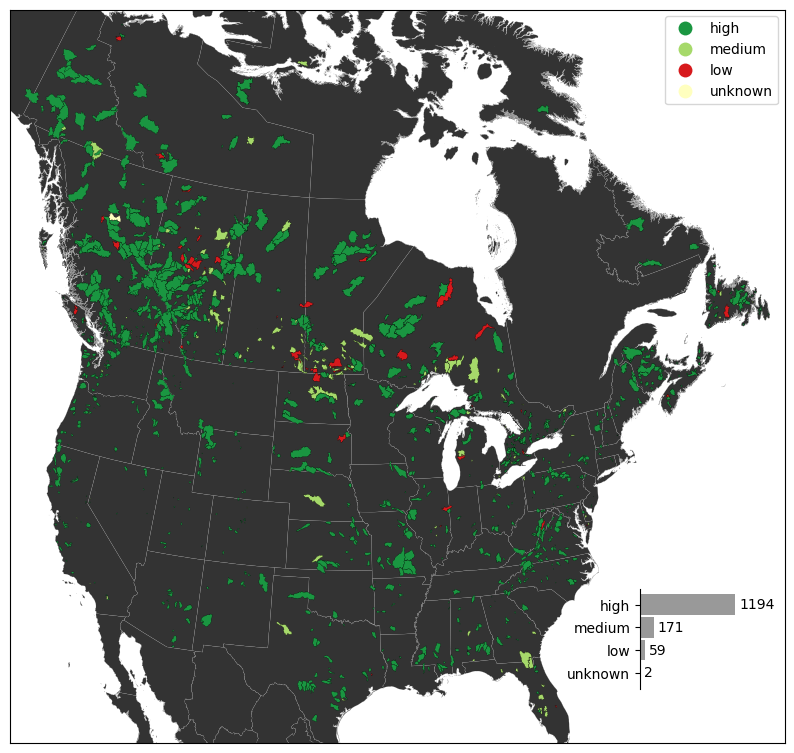

In [156]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

# Background
if have_borders: gdf_borders.plot(ax=ax,facecolor='0.2',edgecolor='0.7', linewidth=0.1)

# Basins
gdf_ea.plot(column = 'plot_col', cmap=cmap, edgecolor='k',
            ax=ax, legend = True, linewidth=.1)

# Chart junk
ax.set_xlim([-2.5*1e6, 3.1*1e6])
ax.set_ylim([-1.6*1e6, 3.7*1e6])
replace_legend_items(ax.get_legend(), legend_dict)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels

## --- Add a small histogram with counts
# Create a new axis for the histogram
ax_hist = plt.axes([0.755, 0.1825, 0.1, 0.1])  # [left, bottom, width, height]

# Add the histogram
value_counts = gdf_ea['Delineation_confidence'].value_counts()
bars = value_counts.plot(kind='barh', color='0.6', width=0.9, ax=ax_hist)

ax_hist.invert_yaxis()
ax_hist.set_ylabel('')

# Add callouts with bin counts
for bar, count in zip(bars.patches, value_counts):
    width = bar.get_width()
    ax_hist.annotate(f'{count}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # Adjust the position of the text
                textcoords='offset points',
                ha='left', va='center')

# Disable top, right, and bottom spines
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['bottom'].set_visible(False)

# Remove x-axis ticks and labels
ax_hist.set_xticks([])
ax_hist.set_xticklabels([]);

## --- Save to file
plt.savefig(image_path / 'delineation_results.png', dpi=300, bbox_inches='tight')

### Check if we have any non-contributing areas in our dataset

In [172]:
has_no_downstream_segment = []
for ix,row in cs_meta.iterrows():
    
    # Construct the path to the distributed shapefile
    basin_str = '_'.join([row['Country'],row['Station_id']])
    riv_shp = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_river.shp')
    
    # Open the shape and get the geometry
    shp = gpd.read_file(riv_shp)

    # Check if we have a stream segment that drains into 0 
    # This means either a connection to an ocean or non-contributing area
    if (shp['NextDownID'] == 0).sum() > 0:
        has_no_downstream_segment.append(basin_str)

In [174]:
tmp_folder = Path('/Users/wmk934/data/CAMELS_spat/camels-spat-data/TEMP_images_no_downstream_segment')
for basin_str in has_no_downstream_segment:
    bas_shp = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_basin.shp')
    riv_shp = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_river.shp')
    bas = gpd.read_file(bas_shp)
    riv = gpd.read_file(riv_shp)
    fix,ax = plt.subplots()
    bas.plot(ax=ax, color='0.8')
    riv.plot(ax=ax, color='blue')
    plt.title(basin_str)
    plt.savefig(tmp_folder / (basin_str + '.png'), dpi=300)
    plt.close()

We checked if any river segments in the database have `NextDownID` == 0, which indicates that that segment is not connected to anything downstream. This would be the case for coastal basins (draining into an ocean) and non-contributing basins (i.e., not connected to a larger downstream basin). Visual inspection of the 60 basins identified to have a river segment with `NextDownID` = 0 indicates that these are all coastal basins.